In [1]:
using Pkg
Pkg.activate(normpath(joinpath(@__DIR__, "..")))

In [2]:
using AbstractGPs
using KernelFunctions
using LinearMixingModels
using LinearAlgebra
using Plots
using Random
using Statistics
using StatsBase

In [3]:
using KernelFunctions: MOInputIsotopicByOutputs

We will assume a setting similar to the defaults we see in MISO. This means 20 latent variables ($m$) with 600 outputs ($p$), ie $H \in \mathbb{R}^{600 \times 20}$, the mixing matrix, would be the first 20 Principal Components of PCA.

For the purpose of this tutorial, we will randomly generate $H$, while enforcing orthogonality in the column space, as would be the case if they were the eigenvectors of the covariance obtained via PCA.

In [4]:
rng = Random.seed!(12345)
U, S, _ = svd(rand(rng, 600, 20));
H = Orthogonal(U, Diagonal(S));

In [5]:
sogp = GP(Matern52Kernel())
latent_gp = independent_mogp([sogp for _ in 1:20]);
oilmm = ILMM(latent_gp, H);
ilmm = ILMM(latent_gp, collect(H));

In [22]:
x = range(0.0, 20.0; length=576)
ys = rand(rng, GP(Matern52Kernel())(x, 1e-6), 600)
indices = sort(sample(1:576, 24; replace=false))
x_train = [x[i] for i in 1:576 if i ∉ indices]
y_train = [ys[i, :] for i in 1:576 if i ∉ indices]
x_test = [x[i] for i ∈ indices]
y_test = [ys[i, :] for i ∈ indices]
x_train = MOInputIsotopicByOutputs(x_train, 600)
x_test = MOInputIsotopicByOutputs(x_test, 600)
y_train = reduce(vcat, reduce(vcat, y_train'))
y_test = reduce(vcat, reduce(vcat, y_test'))

return x_train, x_test, y_train, y_test;

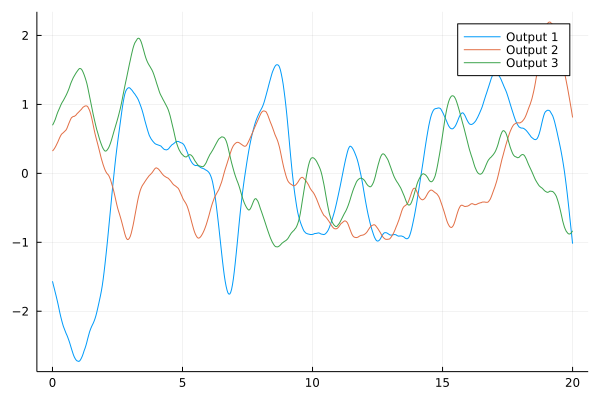

In [23]:
plot(x_train.x, y_train[1:552]; label = "Output 1")
plot!(x_train.x, y_train[553:1104]; label = "Output 2")
plot!(x_train.x, y_train[1105:1656]; label = "Output 3")

In [24]:
@time ilmmx = ilmm(x_train, 0.1);

  0.000020 seconds (13 allocations: 368 bytes)


In [25]:
@time oilmmx = oilmm(x_train, 0.1);

  0.000019 seconds (13 allocations: 368 bytes)


In [26]:
@time p_ilmmx = posterior(ilmmx, y_train);

 32.621439 seconds (365.65 M allocations: 76.371 GiB, 14.49% gc time)


In [27]:
@time p_oilmmx = posterior(oilmmx, y_train);

  0.526617 seconds (399 allocations: 186.856 MiB, 63.89% gc time)


In [28]:
@time logpdf(ilmmx, y_train)

 33.669888 seconds (365.65 M allocations: 76.382 GiB, 13.92% gc time)


-1.5222439095224058e6

In [29]:
@time logpdf(oilmmx, y_train)

  0.286128 seconds (605 allocations: 194.973 MiB, 49.42% gc time)


-1.5222439095224056e6

In [30]:
@time pi = p_ilmmx(x_test, 0.1);

  0.000019 seconds (13 allocations: 560 bytes)


In [31]:
@time po = p_oilmmx(x_test, 0.1);

  0.000022 seconds (13 allocations: 368 bytes)


In [32]:
@time logpdf(pi, y_test)

  2.824083 seconds (16.59 M allocations: 3.393 GiB, 23.71% gc time)


-64348.89038506002

In [33]:
@time logpdf(po, y_test)

  0.029026 seconds (903 allocations: 12.570 MiB)


-64348.89038506001